In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import random
from tqdm import tqdm
from pathlib import Path
import os



In [2]:
BASE_DIR = Path.cwd()
DATASET_PATH = BASE_DIR / 'data' / 'dataset'
CATEGORIES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
TARGET_COUNT = 620
SEED = 42


In [3]:
def getImages(categoryPath):
    return list(categoryPath.glob('*.jpg'))


def printCategoryCounts():
    print("\nImage counts per category:")
    print("-" * 30)
    for categoryName in CATEGORIES:
        categoryPath = DATASET_PATH / categoryName
        imageCount = len(getImages(categoryPath))
        print(f"{categoryName:15s}: {imageCount} images")


def validateAndCleanDataset():
    if not DATASET_PATH.exists():
        raise FileNotFoundError(f"Dataset not found at: {DATASET_PATH}")
    print("Validating dataset for corrupted images...")
    categoryDirectories = [directory for directory in DATASET_PATH.iterdir() if directory.is_dir()]
    print(f"Found {len(categoryDirectories)} categories: {[category.name for category in categoryDirectories]}\n")
    totalRemovedImages = 0
    for categoryDirectory in sorted(categoryDirectories):
        imageFiles = [file for file in categoryDirectory.iterdir() if file.is_file()]
        removedCount = 0
        for imagePath in imageFiles:
            if cv2.imread(str(imagePath)) is None:
                print(f"Removing: {imagePath.name} as it is corrupted.")
                try:
                    os.remove(imagePath)
                    removedCount += 1
                except Exception as error:
                    print(f"Warning: Could not remove: {error}")
        numberOfValidImages = len(imageFiles) - removedCount
        print(f"{categoryDirectory.name}: {numberOfValidImages}/{len(imageFiles)} valid images")
        totalRemovedImages += removedCount
    print(f"\nValidation complete. Removed {totalRemovedImages} corrupted file(s).")
    printCategoryCounts()


def augmentImage(image):
    height, width = image.shape[:2]
    center = (width / 2, height / 2)
    augmentations = [
        cv2.flip(image, 1),  # Horizontal flip
        cv2.flip(image, 0),  # Vertical flip
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 90, 1.0), (width, height)), # 90 degrees
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 180, 1.0), (width, height)), # 180 degrees
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 270, 1.0), (width, height)), # 270 degrees
        cv2.convertScaleAbs(image, alpha=1.3, beta=30),   # Brightness +30
        cv2.convertScaleAbs(image, alpha=0.7, beta=-30),  # Brightness -30
        cv2.GaussianBlur(image, (5, 5), 0),               # Gaussian blur 5x5
    ]
    # Zoom crop
    scale = 1.2
    newHeight, newWidth = int(height * scale), int(width * scale)
    resized = cv2.resize(image, (newWidth, newHeight))
    startHeight, startWidth = (newHeight - height) // 2, (newWidth - width) // 2
    augmentations.append(resized[startHeight:startHeight + height, startWidth:startWidth + width])
    return augmentations


def augmentDataset():
    print(f"\nAugmenting images to reach {TARGET_COUNT} per category...")
    random.seed(SEED)  
    for categoryName in CATEGORIES:
        categoryPath = DATASET_PATH / categoryName
        imagePaths = sorted(getImages(categoryPath))
        currentImageCount = len(imagePaths)
        imagesNeeded = TARGET_COUNT - currentImageCount
        print(f"\n{categoryName}: {currentImageCount} images", end="")
        if imagesNeeded <= 0:
            print(" - Already sufficient")
            continue
        print(f" (Need {imagesNeeded} more)")
        # Load original images using tqdm for progress
        originalImages = [(cv2.imread(str(imageFile)), imageFile.stem) for imageFile in tqdm(imagePaths, desc="Loading")]
        originalImages = [(image, name) for image, name in originalImages]
        # Generate augmented images
        generatedCount = 0
        while generatedCount < imagesNeeded:
            image, imageName = random.choice(originalImages)
            for augmentationIndex, augmentedImage in enumerate(augmentImage(image)):
                if generatedCount >= imagesNeeded:
                    break
                savePath = categoryPath / f"{imageName}_augmented_{generatedCount}_{augmentationIndex}.jpg"
                cv2.imwrite(str(savePath), augmentedImage)
                generatedCount += 1
        print(f"Generated {generatedCount} augmented images")
    print("\n" + "=" * 50)
    print("Augmentation complete.")
    printCategoryCounts()



In [4]:
validateAndCleanDataset()


Validating dataset for corrupted images...
Found 6 categories: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

cardboard: 620/620 valid images
glass: 620/620 valid images
metal: 620/620 valid images
paper: 620/620 valid images
plastic: 620/620 valid images
trash: 620/620 valid images

Validation complete. Removed 0 corrupted file(s).

Image counts per category:
------------------------------
cardboard      : 620 images
glass          : 620 images
metal          : 620 images
paper          : 620 images
plastic        : 620 images
trash          : 620 images


In [5]:
augmentDataset()



Augmenting images to reach 620 per category...

cardboard: 620 images - Already sufficient

glass: 620 images - Already sufficient

metal: 620 images - Already sufficient

paper: 620 images - Already sufficient

plastic: 620 images - Already sufficient

trash: 620 images - Already sufficient

Augmentation complete.

Image counts per category:
------------------------------
cardboard      : 620 images
glass          : 620 images
metal          : 620 images
paper          : 620 images
plastic        : 620 images
trash          : 620 images


In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn. metrics import classification_report, accuracy_score, confusion_matrix

IMG_SIZE = 128

def extract_color_histogram(img, bins=32):
    """Extract color histogram features from HSV color space."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180]).flatten()
    hist_s = cv2.calcHist([hsv], [1], None, [bins], [0, 256]).flatten()
    hist_v = cv2.calcHist([hsv], [2], None, [bins], [0, 256]).flatten()
    # Normalize histograms
    hist_h = hist_h / (hist_h.sum() + 1e-7)
    hist_s = hist_s / (hist_s.sum() + 1e-7)
    hist_v = hist_v / (hist_v. sum() + 1e-7)
    return np.concatenate([hist_h, hist_s, hist_v])

def extract_hu_moments(img):
    """Extract Hu Moments (shape descriptor) from grayscale image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    # Log transform to reduce dynamic range
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    return hu_moments

def extract_edge_features(img, bins=32):
    """Extract edge orientation histogram using Sobel gradients."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    orientation = np.arctan2(sobely, sobelx) * (180 / np. pi) + 180  # 0-360 degrees
    hist, _ = np.histogram(orientation, bins=bins, range=(0, 360), weights=magnitude)
    hist = hist / (hist.sum() + 1e-7)  # Normalize
    return hist

def extract_texture_features(img):
    """Extract simple texture statistics from grayscale image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Laplacian variance (measure of texture/edges)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    # Local Binary Pattern-like statistics (simplified)
    mean_val = np.mean(gray)
    std_val = np.std(gray)
    return np.array([laplacian_var, mean_val, std_val])

def extract_features(img_path):
    """Extract all features from an image."""
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    color_hist = extract_color_histogram(img)       # 96 features (32*3)
    hu_moments = extract_hu_moments(img)            # 7 features
    edge_hist = extract_edge_features(img)          # 32 features
    texture = extract_texture_features(img)         # 3 features
    
    return np.concatenate([color_hist, hu_moments, edge_hist, texture])

print(f"Feature vector size: {96 + 7 + 32 + 3} dimensions")

Feature vector size: 138 dimensions


In [7]:
# Rebuild rows from disk
rows = []
for category_dir in DATASET_PATH. iterdir():
    if category_dir. is_dir():
        category = category_dir.name
        for img_path in category_dir.iterdir():
            if img_path.is_file() and img_path.suffix. lower() in {".jpg", ".jpeg", ".png"}: 
                rows.append({"filename": str(img_path), "category": category})

df = pd.DataFrame(rows)
print(f"Total images found: {len(df)}")

# Extract features for all images
features, labels = [], []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    feat = extract_features(row["filename"])
    if feat is not None:
        features.append(feat)
        labels.append(row["category"])

X = np. array(features, dtype=np.float32)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nDataset split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples:   {len(X_test)}")
print(f"  Feature dimensions: {X.shape[1]}")
print(f"  Classes: {list(le.classes_)}")

Total images found: 3720


Extracting features: 100%|██████████| 3720/3720 [00:16<00:00, 227.26it/s]



Dataset split:
  Training samples: 2976
  Testing samples:   744
  Feature dimensions: 138
  Classes: [np.str_('cardboard'), np.str_('glass'), np.str_('metal'), np.str_('paper'), np.str_('plastic'), np.str_('trash')]


In [8]:
# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Experiment with different k values
k_values = [1, 3, 5, 7, 9, 11, 15]
results = []

print("=" * 60)
print("KNN Experiments with Different k Values")
print("=" * 60)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    
    train_acc = accuracy_score(y_train, knn. predict(X_train_scaled))
    test_acc = accuracy_score(y_test, knn. predict(X_test_scaled))
    
    results.append({'k': k, 'train_acc':  train_acc, 'test_acc':  test_acc})
    print(f"k={k: 2d}  |  Train Accuracy: {train_acc:.4f}  |  Test Accuracy: {test_acc:.4f}")

# Find best k
best_result = max(results, key=lambda x:  x['test_acc'])
print("\n" + "=" * 60)
print(f"Best k = {best_result['k']} with Test Accuracy = {best_result['test_acc']:.4f}")
print("=" * 60)

KNN Experiments with Different k Values
k= 1  |  Train Accuracy: 0.9997  |  Test Accuracy: 0.8239
k= 3  |  Train Accuracy: 0.9997  |  Test Accuracy: 0.7957
k= 5  |  Train Accuracy: 0.9997  |  Test Accuracy: 0.7769
k= 7  |  Train Accuracy: 0.9997  |  Test Accuracy: 0.7742
k= 9  |  Train Accuracy: 0.9997  |  Test Accuracy: 0.7702
k= 11  |  Train Accuracy: 0.9997  |  Test Accuracy: 0.7688
k= 15  |  Train Accuracy: 0.9997  |  Test Accuracy: 0.7581

Best k = 1 with Test Accuracy = 0.8239


In [9]:
# Train final model with best k
best_k = best_result['k']
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights='distance', n_jobs=-1)
knn_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = knn_best.predict(X_train_scaled)
y_test_pred = knn_best.predict(X_test_scaled)

# Final accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Final KNN Model (k={best_k})")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:   {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("=" * 60)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

print("\nClassification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Pretty print confusion matrix
print("\nConfusion Matrix (formatted):")
print(f"{'':15s}", end="")
for cls in le.classes_:
    print(f"{cls:>10s}", end="")
print()
for i, cls in enumerate(le. classes_):
    print(f"{cls:15s}", end="")
    for j in range(len(le.classes_)):
        print(f"{cm[i, j]:10d}", end="")
    print()

Final KNN Model (k=1)
Training Accuracy: 0.9997 (99.97%)
Testing Accuracy:   0.8239 (82.39%)

Classification Report (Test Set):
              precision    recall  f1-score   support

   cardboard       0.91      0.88      0.89       124
       glass       0.74      0.77      0.75       124
       metal       0.75      0.77      0.76       124
       paper       0.86      0.84      0.85       124
     plastic       0.80      0.77      0.78       124
       trash       0.89      0.93      0.91       124

    accuracy                           0.82       744
   macro avg       0.82      0.82      0.82       744
weighted avg       0.82      0.82      0.82       744


Classification Report (Train Set):
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00       496
       glass       1.00      1.00      1.00       496
       metal       1.00      1.00      1.00       496
       paper       1.00      1.00      1.00       496
     plastic       1.0

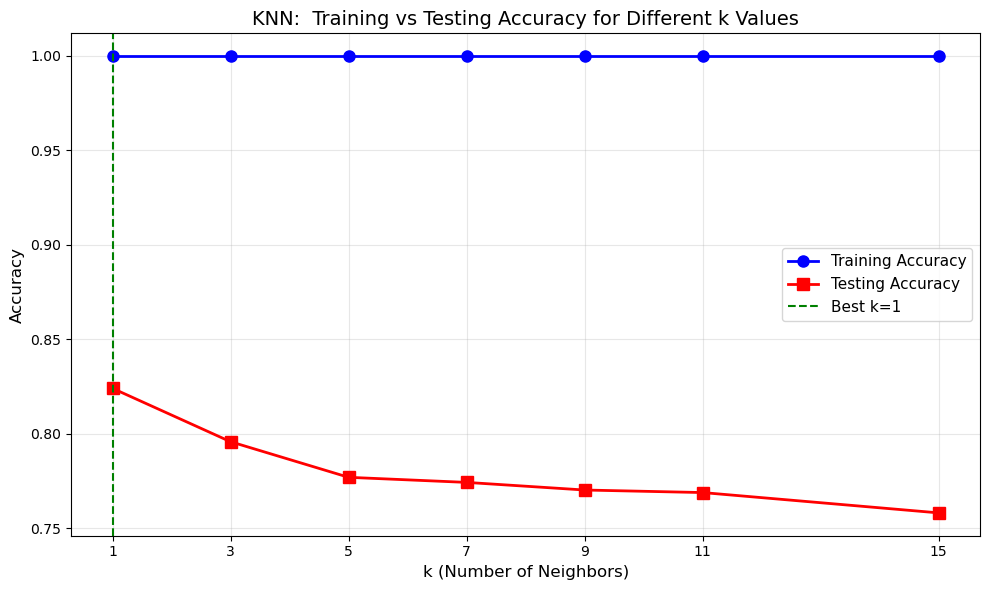

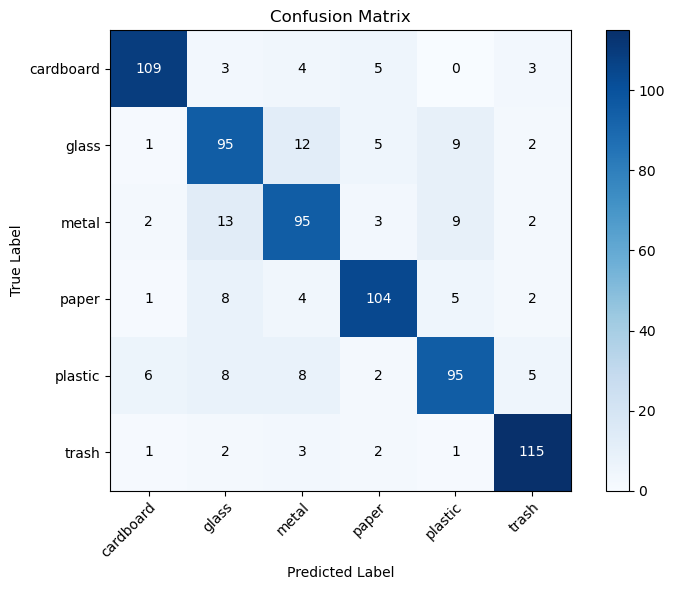

In [10]:
import matplotlib.pyplot as plt

# Plot k vs accuracy
fig, ax = plt. subplots(figsize=(10, 6))
k_vals = [r['k'] for r in results]
train_accs = [r['train_acc'] for r in results]
test_accs = [r['test_acc'] for r in results]

ax. plot(k_vals, train_accs, 'b-o', label='Training Accuracy', linewidth=2, markersize=8)
ax.plot(k_vals, test_accs, 'r-s', label='Testing Accuracy', linewidth=2, markersize=8)
ax.axvline(x=best_k, color='green', linestyle='--', label=f'Best k={best_k}')

ax.set_xlabel('k (Number of Neighbors)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('KNN:  Training vs Testing Accuracy for Different k Values', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(k_vals)
plt.tight_layout()
plt.show()

# Plot confusion matrix heatmap
fig, ax = plt. subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=le.classes_,
       yticklabels=le.classes_,
       title='Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm. shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()